<a href="https://colab.research.google.com/github/LorenzoPiccari/LorenzoPiccari/blob/main/PyTorch_SimpleMLP_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Implementation of a basic pytorch MLP shallow architecture to illustrate
# a tipical DL pipeline implemented in pytorch
#
# Stefano Giagu - v1.1 - 4.11.2022

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [ ]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [ ]:
# in torch/pytorch data and models need to be moved in the specific processing unit
# this code snippet allows to set the variable "device" according to available resoirce (cpu or cuda gpu)

if torch.cuda.is_available():
  print('number fo devices: ', torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

number fo devices:  1
Tesla T4
Computation device: cuda



In [ ]:
# Dataset: in this super simple example, we'll produce a toy dataset generated using
# numpy
#
# two class problem, with 8 uncorrelated features, gaussian distributed with different
# means and variance among features and classes

#loc is the list of mean values for the distribution, scale is the stdev
features_S = np.random.normal(loc=[-4.,-3.,-2.,-1.,1.,2.,3.,4.], scale=np.random.uniform(0.2,0.7,size=(8)), size=(2000,8))
features_B = np.random.normal(loc=[-4.5,-3.5,-2.5,-1.5,1.5,2.5,3.5,4.5], scale=np.random.uniform(0.2,0.7,size=(8)), size=(2000,8))
labels_S = np.zeros(shape=(2000))
labels_B = np.ones(shape=(2000))

X = np.concatenate((features_S, features_B), axis=0)
Y = np.concatenate((labels_S, labels_B), axis=0)
print(X.shape)

# divide the dataset in train and test
from sklearn.model_selection import train_test_split

#0.2 of datapoints to the test set and 0.8 to the training set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12345)
#Divide the training set in training set and validation set, 0.2 to validation and 0.8 to training
X_train, X_vali, Y_train, Y_vali = train_test_split(X_train, Y_train, test_size=0.2, random_state=456789)
print(X_train.shape)
print(Y_train.shape)
print(X_vali.shape)
print(Y_vali.shape)
print(X_test.shape)
print(Y_test.shape)

#Each event/point in these datasets is constitued by a label (0 or 1 in the Y) and a set of 8 uncorraletd features which represent the single event:
print(X_train[0])
print(Y_train[0])

(4000, 8)
(2560, 8)
(2560,)
(640, 8)
(640,)
(800, 8)
(800,)
[-3.6496617  -2.85458647 -1.4130614  -0.87017962  1.14717446  2.1533301
  3.14323779  3.70608474]
0.0


(array([ True,  True, False, ...,  True,  True, False]),)
(array([False, False,  True, ..., False, False,  True]),)


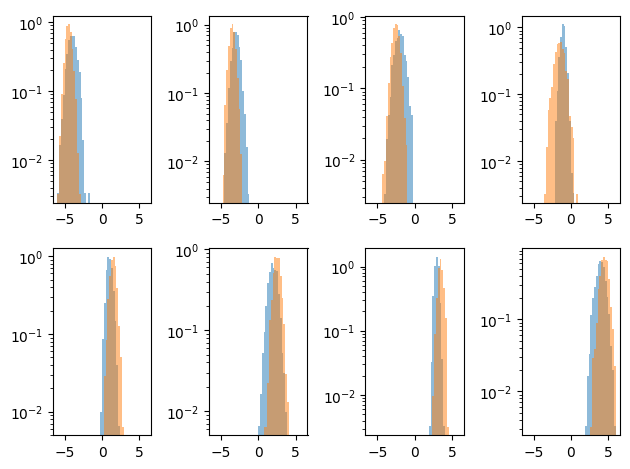

In [ ]:
# plot variables

#Y can be only 1 or 0, which in this case are the labels for the two classes we are condidering, so:
sel_S = tuple([Y_train<0.5])
sel_B = tuple([Y_train>0.5])
print(sel_S)
print(sel_B)

#Each of the 8 uncorrelated features, will have some points labelled with 0 and others with 1, in a random way.
for idx in range(8):
  plt.subplot(2,4,idx+1)
  plt.hist((X_train[sel_S])[:,idx], bins=50, range=[-6.,6.], alpha=0.5, log=True, density=True)
  plt.hist((X_train[sel_B])[:,idx], bins=50, range=[-6.,6.], alpha=0.5, log=True, density=True)
plt.tight_layout()

In [ ]:
# transform the numpy arrays to torch tensors (pytorch works with torch tensors)

X_train_pt = torch.Tensor(X_train).float()
Y_train_pt = torch.Tensor(Y_train).float()
X_vali_pt = torch.Tensor(X_vali).float()
Y_vali_pt = torch.Tensor(Y_vali).float()
X_test_pt = torch.Tensor(X_test).float()
Y_test_pt = torch.Tensor(Y_test).float()

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_vali_pt.shape)
print(Y_vali_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

# For training and validation set, create a pytorch dataset and a pytroch dataloader (a python iterable that allows to iterate among sample's events, mini-batch it, reshuffle it at every epoch, etc...)
from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt)
#Iterating on this iterator means taking each iteration a minibatch of 32 elements
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_vali = TensorDataset(X_vali_pt, Y_vali_pt)
dataloader_vali = DataLoader(dataset_vali, batch_size=32, shuffle=True)

torch.Size([2560, 8])
torch.Size([2560])
torch.Size([640, 8])
torch.Size([640])
torch.Size([800, 8])
torch.Size([800])


In [ ]:
# note: move torch tensors between cpu and gpu

print('X_train_pt is in GPU: ', X_train_pt.is_cuda)
X_train_pt = X_train_pt.to(device)
print('X_train_pt is in GPU: ', X_train_pt.is_cuda)
X_train_pt = X_train_pt.to('cpu')
print('X_train_pt is in GPU: ', X_train_pt.is_cuda)


# alteranative way (earlier troch style)
# use .cuda() e .cpu()
print('X_train_pt is in GPU: ', X_train_pt.cpu())
print('X_train_pt is in GPU: ', X_train_pt.cuda())

X_train_pt is in GPU:  False
X_train_pt is in GPU:  True
X_train_pt is in GPU:  False
X_train_pt is in GPU:  tensor([[-3.6497, -2.8546, -1.4131,  ...,  2.1533,  3.1432,  3.7061],
        [-3.9076, -3.1320, -2.8785,  ...,  2.3186,  3.0983,  3.5820],
        [-5.0216, -3.3958, -2.3451,  ...,  3.4292,  4.2951,  4.5154],
        ...,
        [-2.9472, -3.0311, -1.8128,  ...,  1.2947,  2.9858,  3.5900],
        [-4.0767, -2.7730, -1.6745,  ...,  1.4975,  3.3151,  4.0481],
        [-4.6551, -3.1671, -2.2284,  ...,  2.6399,  3.4119,  5.8523]])
X_train_pt is in GPU:  tensor([[-3.6497, -2.8546, -1.4131,  ...,  2.1533,  3.1432,  3.7061],
        [-3.9076, -3.1320, -2.8785,  ...,  2.3186,  3.0983,  3.5820],
        [-5.0216, -3.3958, -2.3451,  ...,  3.4292,  4.2951,  4.5154],
        ...,
        [-2.9472, -3.0311, -1.8128,  ...,  1.2947,  2.9858,  3.5900],
        [-4.0767, -2.7730, -1.6745,  ...,  1.4975,  3.3151,  4.0481],
        [-4.6551, -3.1671, -2.2284,  ...,  2.6399,  3.4119,  5.8523]],


In [ ]:
# example of iteration through the dataloader

train_features, train_labels = next(iter(dataloader_train))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

an_event = train_features[0].squeeze()
a_label = train_labels[0]

print(f"Feature: {an_event}")
print(f"Label: {a_label}")

Feature batch shape: torch.Size([32, 8])
Labels batch shape: torch.Size([32])
Feature: tensor([-4.4314, -3.2058, -2.0983, -1.2304,  2.2139,  2.6515,  3.3059,  4.2845])
Label: 1.0


In [ ]:
# a pytorch nn (Neural Network) model: it is just a python class inheriting from nn.Module that defines
# the layers and activations used in the Deep Neural Network model and a forward(x) method that defines
# how the model act on an input example x

from torch import nn
import torch.nn.functional as F

# as a basic example let'd define a shallow ANN with a dense layer with 20 neurons
class ShallowANN(nn.Module):
  def __init__(self, input_dim):
    super(ShallowANN, self).__init__()

    #torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    #Linear in pytorch is the equivalent of Dense in keras
    #So there are 2 layers, with 20 neurons each. The activation function change for each layer. For the hidden layer we have ReLU (Rectified linear unit), which is very common for hidden layers.
    #For the output layer we have instead a Sigmoid, which is indeed tipycally used for the output layer of classification tasks.
    self.layer1 = nn.Linear(input_dim, 20)
    self.activ1 = nn.ReLU()
    self.layer2 = nn.Linear(20, 1)
    self.activ2 = nn.Sigmoid()

  def forward(self, x):
    out = self.layer1(x)
    out = self.activ1(out)
    out = self.layer2(out) #alternatively the two statements can be replaced
    out = self.activ2(out) #out = torch.sigmoid(self.layer2(out))
    return out

# note: it is strightfoward to modify the class to implement a MLP

# example MLP: with 3 hidden layers

class MyMLP(nn.Module):
  def __init__(self):
    super(MyMLP, self).__init__()

    self.layer1 = nn.Linear(8, 20)
    self.activ1 = nn.ReLU()
    self.layer2 = nn.Linear(20, 50)
    self.activ2 = nn.ReLU()
    self.layer3 = nn.Linear(50, 100)
    self.activ3 = nn.ReLU()
    self.layer4 = nn.Linear(100, 1)
    self.activ4 = nn.Sigmoid()

  def forward(self, x):
    out = self.layer1(x)
    out = self.activ1(out)
    out = self.layer2(out)
    out = self.activ2(out)
    out = self.layer3(out)
    out = self.activ3(out)
    out = self.layer4(out)
    out = self.activ4(out)
    return out


# alternative implementation
class MyMLP2(nn.Module):
  def __init__(self):
    super(MyMLP2, self).__init__()

    self.mlp_block = nn.Sequential( #similar to keras keras.Sequential module
      nn.Linear(8, 20),
      nn.ReLU(),
      nn.Linear(20, 50),
      nn.ReLU(),
      nn.Linear(50, 100),
      nn.ReLU()
    )

    self.out_block = nn.Linear(100, 1)

  def forward(self, x):
    out = torch.sigmoid(self.out_block(self.mlp(x)))
    return out

In [ ]:
%pip install torchsummary

In [ ]:
model = ShallowANN(input_dim=8)
print(model)

#Giving a summary of the model and the training with torchsummary
from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,8))
else:
  summary(model, input_size=(1,8))

ShallowANN(
  (layer1): Linear(in_features=8, out_features=20, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=20, out_features=1, bias=True)
  (activ2): Sigmoid()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 20]             180
              ReLU-2                [-1, 1, 20]               0
            Linear-3                 [-1, 1, 1]              21
           Sigmoid-4                 [-1, 1, 1]               0
Total params: 201
Trainable params: 201
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics]
# API = Application Programming Interface (interfaccia di programmazione delle applicazioni
%pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 4.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
# reinstantiate a new model (reset weight etc) and put it on GPU
model = ShallowANN(input_dim=8)
model.to(device)
print('model is on GPU: ',next(model.parameters()).is_cuda)

model is on GPU:  True


In [ ]:
#loss

# NOTE: BCELoss for binary classification
#       CrossEntropyLoss for multiclass classification (already includes softmax calculation, output of ANN foward method are logits)
loss_func = nn.BCELoss() #binary cross entropy loss

#Cross entropy is the term used to indicate the negative log-likelihood of a Bernoulli (BCE) or softmax distribution [https://it.wikipedia.org/wiki/Funzione_softmax]

# metrics
import torchmetrics
from torchmetrics.functional.classification import binary_accuracy

#metric binary accuracy (hand's made)
#yhat --> empirical data defined by the training set
#y --> Model
def my_binary_accuracy(yhat, y):
  #assert tells the program to immediately test a condition and raise an error if it's False
  #Here we are basically checking the validity of the input arguments
  assert y.ndim == 1 and y.size() == yhat.size()
  #If yhat > 0.5 --> yhat = True, else yhat = False
  yhat = yhat > 0.5
  #Count how many times the elements of y match those of y and divide by the total number of elements
  return (y == yhat).sum().item() / y.size(0)

my_metric_func = my_binary_accuracy

# NOTE: better to use metrics from torchmetrics:
#  torchmetrics.functional.classification.binary_accuracy(preds, target)

# optim
from torch import optim

#The standard minimization algoritm is Stochastic Gradien Descent
#opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# However, we can also pick alternatives, as Adam
opt = optim.Adam(model.parameters(), lr=1e-3)

#The Adam optimizer, short for “Adaptive Moment Estimation,” is an iterative optimization algorithm used
#to minimize the loss function during the training of neural networks. Adam can be looked at
#as a combination of RMSprop and Stochastic Gradient Descent with momentum

# scheduler for multi step decay lr schedule
# Decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones
#lr_scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[20,40,60], gamma=0.1)

In [ ]:
# test implementation on one batch before to train. Remember in this notebook we have defined the dataloader iterator
# to iterate over mini batches of 32 elements each
xb,yb = next(iter(dataloader_train))

#next() and iter() are built-in functions of python, they are used for working with iterables.
#Basically iter() calls the __iter__() method on the iris_loader which returns an iterator. next() then calls the __next__() method on that iterator to get the first iteration.
#Running next() again will get the second item of the iterator, etc.
#This logic often happens 'behind the scenes', for example when running a for loop.
#It calls the __iter__() method on the iterable, and then calls __next__() on the returned iterator
#until it reaches the end of the iterator. It then raises a stopIteration and the loop stops.
#Source: [https://stackoverflow.com/questions/62549990/what-does-next-and-iter-do-in-pytorchs-dataloader]

xb=xb.type(torch.float).to(device) #put tensors on device
yb=yb.type(torch.float).to(device)

# prediction

#model here is ShallowANN model
pred = model(xb)
print('output shape: ', pred.shape)

# loss and metric
loss = loss_func(pred, torch.unsqueeze(yb,1))
metric = binary_accuracy(pred, torch.unsqueeze(yb,1))
#or also: metric = binary_accuracy(torch.squeeze(pred), yb)
mymetric = my_metric_func(torch.squeeze(pred), yb)

print('loss: ', loss.item())
print('metric: ', metric.item())
print('my_metric: ', mymetric)

output shape:  torch.Size([32, 1])
loss:  0.6447007060050964
metric:  0.65625
my_metric:  0.65625


In [ ]:
#training loop (in pytorch you need to write yourself it (alternatively use PyTorch Lightning for more keras-like APIs))
import time
epochs = 100

# define a couple of lists to store loss and accuracy during training for monitoring purposes
hist_loss = []
hist_metric = []
hist_val_loss = []
hist_val_metric = []

# loop over epochs
for epoch in range(epochs):
    t0 = time.time()

    #training step
    model.train() #important!
    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for xb, yb in dataloader_train: #loop over minibatches
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.float).to(device)
        pred = model(xb)
        loss = loss_func(pred, torch.unsqueeze(yb,1))
        metric = binary_accuracy(pred, torch.unsqueeze(yb,1))
        train_loss += loss.item()
        train_metric += metric.item()

        # backpropagation
        loss.backward()
        opt.step()
        opt.zero_grad()

    train_loss = train_loss/counter
    train_metric = train_metric/counter

    hist_loss.append(train_loss)
    hist_metric.append(train_metric)

    # validation step
    model.eval() #important!
    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    with torch.no_grad():
      for xb, yb in dataloader_vali:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.float).to(device)
        pred = model(xb)
        vloss = loss_func(pred, torch.unsqueeze(yb,1))
        vmetric = binary_accuracy(pred, torch.unsqueeze(yb,1))
        vali_loss += vloss.item()
        vali_metric += vmetric.item()

    vali_loss = vali_loss/counter
    vali_metric = vali_metric/counter

    hist_val_loss.append(vali_loss)
    hist_val_metric.append(vali_metric)

    elapsed_time = time.time()-t0
    #current_lr = lr_scheduler.get_last_lr()[0]
    #print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f, lr : %1.2e"
    #      % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric, current_lr))
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f"
          % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

    # update learning rate schedule
    #lr_scheduler.step()

epoch: 1, time(s): 0.4598, train loss: 0.674505, train metric: 0.567969, vali loss: 0.659332, vali metric: 0.623437
epoch: 2, time(s): 0.3054, train loss: 0.645217, train metric: 0.678125, vali loss: 0.629279, vali metric: 0.734375
epoch: 3, time(s): 0.2268, train loss: 0.620162, train metric: 0.710547, vali loss: 0.601478, vali metric: 0.737500
epoch: 4, time(s): 0.2225, train loss: 0.595659, train metric: 0.729688, vali loss: 0.574961, vali metric: 0.765625
epoch: 5, time(s): 0.2183, train loss: 0.573384, train metric: 0.747656, vali loss: 0.554891, vali metric: 0.743750
epoch: 6, time(s): 0.2242, train loss: 0.553237, train metric: 0.748828, vali loss: 0.534374, vali metric: 0.762500
epoch: 7, time(s): 0.2781, train loss: 0.537143, train metric: 0.751953, vali loss: 0.513123, vali metric: 0.784375
epoch: 8, time(s): 0.2377, train loss: 0.524714, train metric: 0.758203, vali loss: 0.500969, vali metric: 0.779687
epoch: 9, time(s): 0.2179, train loss: 0.511902, train metric: 0.764453,

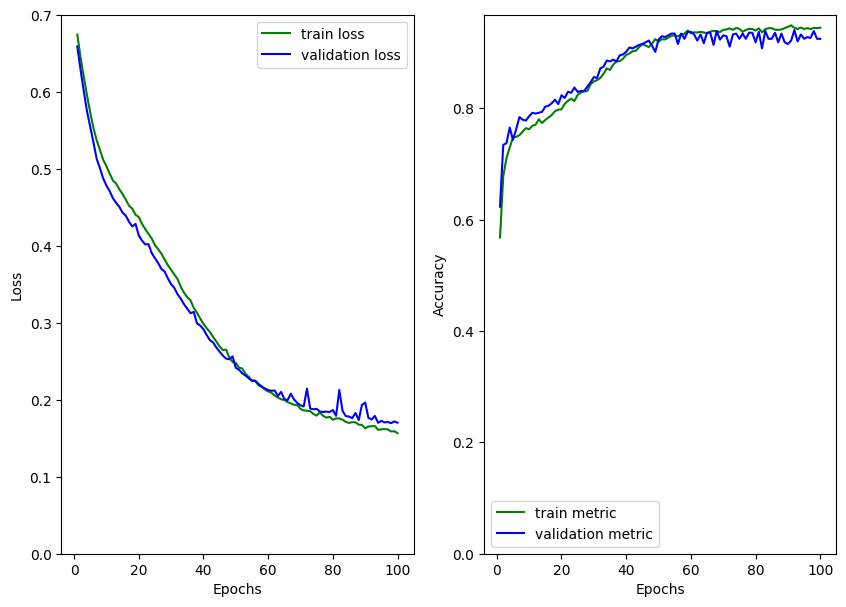

In [ ]:
# plot training results (loss and accuracy vs epoch)
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_val_loss)+1), hist_val_loss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(ymin = 0.0)
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_val_metric)+1),hist_val_metric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(ymin = 0.0)
plt.legend()

In [ ]:
#test the trained model

# let's test it on cpu
model.to(torch.device("cpu"))

X_test_pt = X_test_pt.type(torch.float).to(torch.device("cpu"))
res = model(X_test_pt)

In [ ]:
print('Test accuracy: ',binary_accuracy(res, torch.unsqueeze(Y_test_pt,1)).item())

Test accuracy:  0.9424999952316284
